In [1]:
import bayeslite

In [3]:
satellites_bdb = bayeslite.bayesdb_open("satellites.bdb")
bayeslite.bayesdb_read_csv_file(satellites_bdb, "satellites", "satellites.utf8.csv", 
                                header=True, create=True, ifnotexists=True)
import bayeslite.guess
import bayeslite.crosscat
import crosscat
import crosscat.LocalEngine
crosscat_engine = crosscat.LocalEngine.LocalEngine(seed=0)
crosscat_metamodel = bayeslite.crosscat.CrosscatMetamodel(crosscat_engine)
bayeslite.bayesdb_register_metamodel(satellites_bdb, crosscat_metamodel)
generator = bayeslite.guess.bayesdb_guess_generator(satellites_bdb, 'satellites_cc', 'satellites', 'crosscat', 
                                                    ifnotexists=True)

In [4]:
from bdbcontrib.facade import do_query
df = do_query(satellites_bdb, "SELECT perigee_km, apogee_km, period_minutes, class_of_orbit FROM satellites").as_df()

/Users/gremio/Desktop/Prettier/BayesDB-ventu0.4.1-bayes0.1.dev20150727-256-g2210c72.app/Contents/MacOS/venv/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


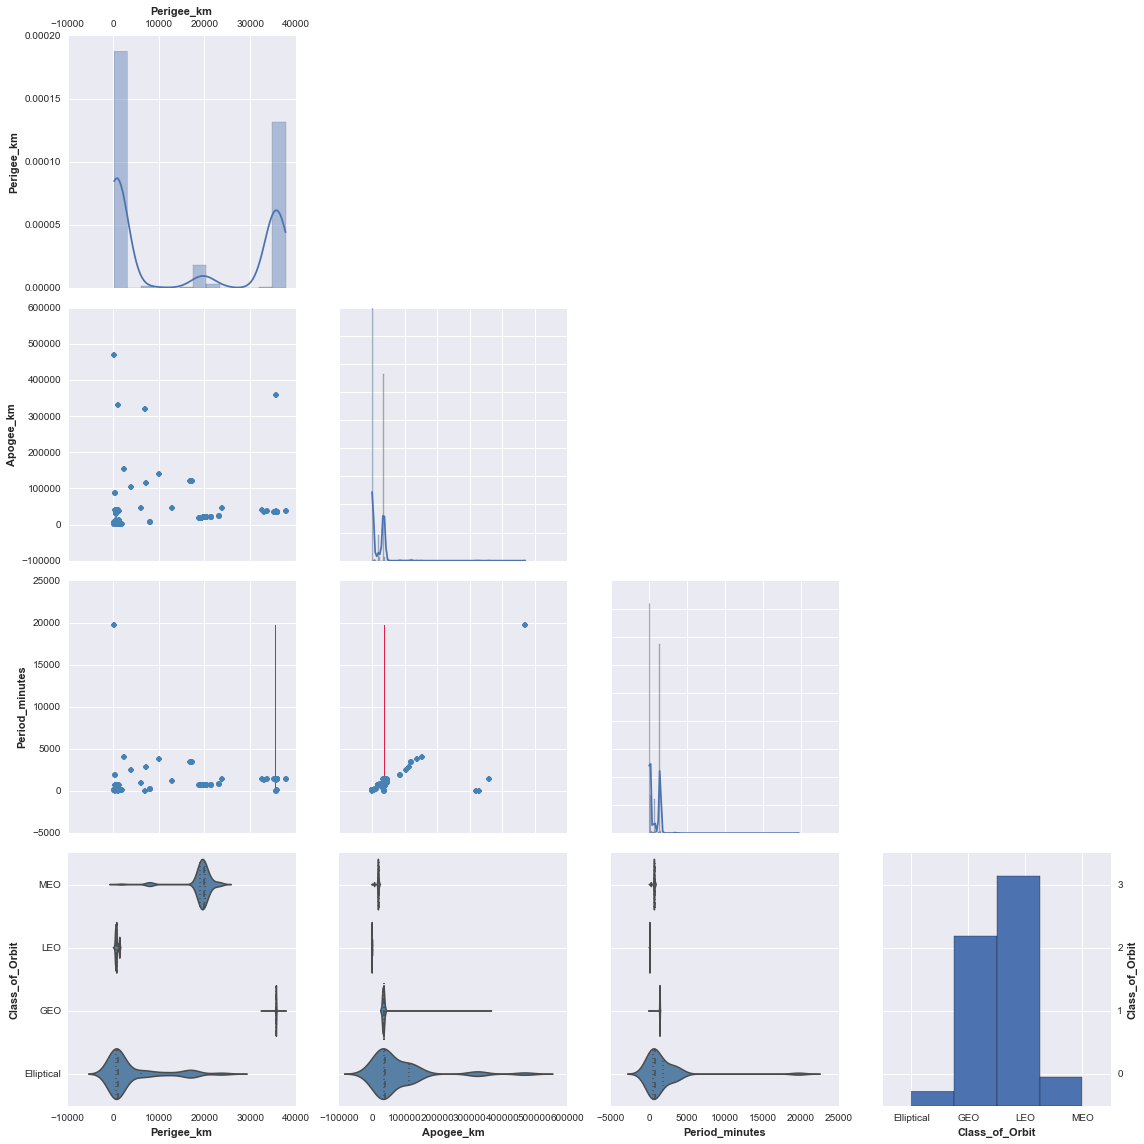

In [20]:
from bdbcontrib import plotutils
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

c = len(df.columns)*4
fig = plt.figure(tight_layout=True, figsize=(c, c))
gs = plotutils.pairplot(df, bdb=satellites_bdb, generator_name='satellites_cc',
                        use_shortname=None, show_contour=False,
                        colorby=None, show_missing=True, show_full=False)
plt.close('all')
# use plt.show() to open a separate window where you won't get a warning about tight_layout, 
# and you will have larger plots to look at.
fig

In [10]:
for row in satellites_bdb.execute("SELECT Name, dry_mass_kg FROM satellites LIMIT 10;"):
    print row

(u'AAUSat-3', u'NaN')
(u'ABS-1 (LMI-1, Lockheed Martin-Intersputnik-1)', 1730)
(u'ABS-1A (Koreasat 2, Mugunghwa 2, ABS-1A)', 800)
(u'ABS-2i (MBSat, Mobile Broadcasting Satellite, Han Byul)', 1700)
(u'ABS-7 (Koreasat 3, Mugungwha 3)', 1800)
(u'AcrimSat (Active Cavity Radiometer Irradiance Monitor)', 13)
(u'Advanced Orion 2 (NROL 6, USA 139)', u'NaN')
(u'Advanced Orion 3 (NROL 19, USA 171)', u'NaN')
(u'Advanced Orion 4 (NRO L-26, USA 202)', u'NaN')
(u'Advanced Orion 5 (NRO L-32, USA 223)', u'NaN')
